**Goal**: Forecast implied volatility (VIX) from past SPX returns using TSPL kernels.  
**Model**: Linear regression on trend (R₁) and volatility (R₂) features.  
**Results**: Test R² ≈ 0.87 — outperforms baseline (R² ≈ 0.56) and HAR model (R² ≈ 0.70).  
**Bonus**: Generalizes well to NDX and DJI volatility indices.

# VIX Volatility Modeling with Long-Memory Kernels (TSPL)

This project implements a volatility forecasting model inspired by the paper *"Volatility is Mostly Path-Dependent"* (Guyon & Lekeufack, 2023).  
The goal is to reconstruct the VIX index dynamically using past returns of the S&P 500, via convolution with long-memory kernels, and to assess the quality and robustness of the prediction.

## Objectives

- Construct normalized convolution kernels to extract long-memory features from returns (`R₁`) and squared returns (`R₂`)
- Predict the VIX level using a linear regression model based on `R₁` and `R₂`
- Calibrate the kernel parameters (`α`, `δ`) using Powell's optimization method
- Evaluate model performance across multiple train/test splits

---

##  Dataset

- **Underlying / Volatility index pairs**:  
  - S&P 500 (^GSPC) / VIX (^VIX)  
  - Nasdaq-100 (^NDX) / VXN (^VXN)  
  - Dow Jones (^DJI) / VXD (^VXD)
- **Period**: 2000 – 2025
- **Source**: [Yahoo Finance](https://finance.yahoo.com)

---

##  Tools and Libraries

- Python (NumPy, Pandas, Matplotlib, Scikit-learn, yfinance)
- Optimization: `scipy.optimize.minimize`
- Modeling: Linear regression on TSPL features

---

## Summary of Key Results

- **Test RMSE (S&P 500)**: ~2.87  
- **Test R² (S&P 500)**: ~0.87  
- Visual and analytical interpretation of **kernel shapes** (R₁ and R₂)  
- Extensive **residual diagnostics**: time series, histogram, ACF, error heatmap  
- **Out-of-sample validation** across multiple indices (Nasdaq 100, Dow Jones)  
- Critical discussion of **model limitations** and proposed **extensions** ( stochastic residuals)



## 1. Data Collection and Preprocessing

We download daily price data for the selected indices and their corresponding volatility indices from Yahoo Finance.  
Then we compute arithmetic returns and merge the time series on their common trading dates.

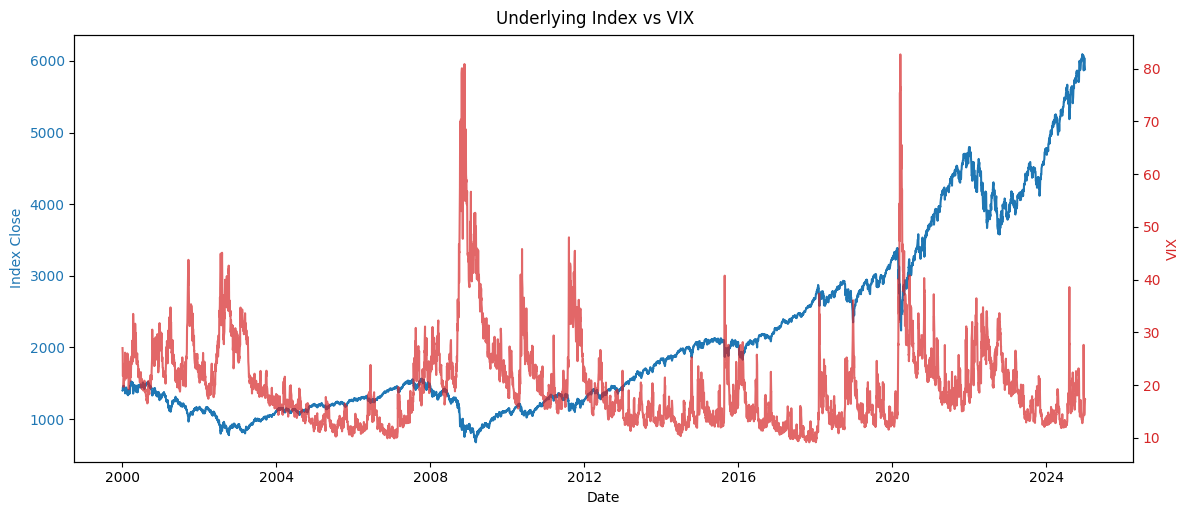

In [40]:
from volatility_project.data import load_market_data
from volatility_project.features import compute_tspl_features
from volatility_project.models import TSPLModel, RealizedVolBaseline, HARModel
from volatility_project.evaluate import generate_time_splits, cross_validate_tspl
from volatility_project.optimization import optimize_tspl_parameters
import pandas as pd
from volatility_project.features import compute_tspl_features, tspl_kernel
from volatility_project.plotting import (
    plot_index_vs_vix,
    plot_tspl_kernels,
    plot_real_vs_pred,
    plot_scatter_real_pred,
    plot_relationship,
    plot_residuals,
    plot_histogram_residuals,
    plot_autocorrelation_residuals,
    plot_realized_vs_pred,
)
import numpy as np
# Chargement des données SPX/VIX
try:
    df = load_market_data('^GSPC', '^VIX', start='2000-01-01', end='2025-01-01')
except ImportError as e:
    print(e)
    df = None

if df is not None:
    returns = df['returns']
    vix = df['vix']
plot_index_vs_vix(df)

## 2. TSPL Kernel Construction

We define the TSPL kernel as a normalized power-law function with two parameters:

- **α (alpha)**: controls the memory decay (higher α → faster decay)
- **δ (delta)**: controls the lag or shift in the response

These kernels are used to compute two features:

- `R₁` = convolution with past returns (trend)
- `R₂` = convolution with past squared returns (volatility)

## 3. Model Calibration and Fitting

We train a linear regression model to predict the VIX based on the computed `R₁` and `R₂` features.  
The kernel parameters are optimized using Powell’s method to minimize the out-of-sample RMSE on the test set.

 **Remark**  
> The smoothing of `R₂` acts as a form of signal filtering aimed at reducing the variance of the feature while preserving the low-frequency information relevant for predicting the VIX.  
> This relies on the assumption that the VIX reflects medium-term expected volatility, rather than an immediate reaction to recent returns.

Optimised TSPL parameters (alpha1, delta1, alpha2, delta2): (2.434430755456752, 19.726731202691283, 0.5812437283819866, 0.021107488942157825)
Mean CV RMSE: 2.40


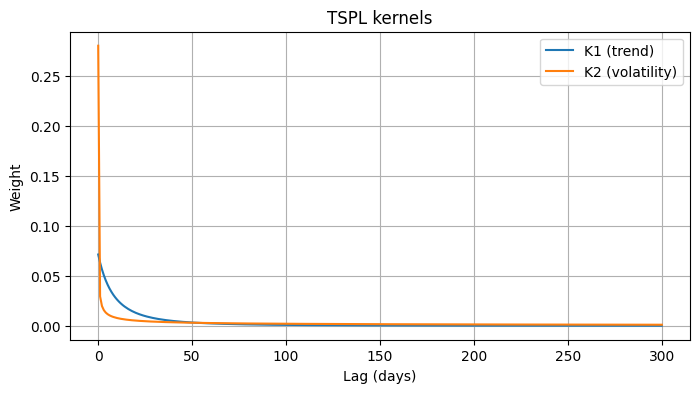

In [41]:
windows = [
        ('2000-01-01', '2015-12-31', '2016-01-01', '2020-12-31'),
        ('2005-01-01', '2015-12-31', '2016-01-01', '2020-12-31'),
        ('2010-01-01', '2017-12-31', '2018-01-01', '2023-12-31'),
    ]
splits = generate_time_splits(df.index, windows)

initial_guess = (3.25, 20.4, 0.73, 0.075)
optimized_params, cv_rmse = optimize_tspl_parameters(
        returns,
        vix,
        splits,
        initial_guess=initial_guess,
        smoothing_span=20,
        method='Powell',
    )
print('Optimised TSPL parameters (alpha1, delta1, alpha2, delta2):', optimized_params)
print(f'Mean CV RMSE: {cv_rmse:.2f}')
alpha1, delta1, alpha2, delta2 = optimized_params
R1, R2 = compute_tspl_features(returns, alpha1, delta1, alpha2, delta2)

k1 = tspl_kernel(alpha1, delta1, T=300)
k2 = tspl_kernel(alpha2, delta2, T=300)
plot_tspl_kernels(k1, k2)

## Interpretation of Optimized Kernel Parameters

The TSPL model uses two convolution kernels to capture the influence of past returns (`R₁`) and past squared returns (`R₂`) on the VIX.  
These kernels are defined by two parameters each:  
- `α`: controls memory decay (how quickly past data lose influence)  
- `δ`: controls delay (how long it takes for past data to start influencing the output)

---

### Optimized Parameters

| Parameter | Value   | Used in | Interpretation |
|-----------|---------|---------|----------------|
| **α₁**    | 2.43  | `R₁` (returns) | Very **short memory** – only very recent returns are considered |
| **δ₁**    | 19.72  | `R₁`           | **Strong delay** – returns influence the VIX with a ~20-day lag |
| **α₂**    | 0.58   | `R₂` (squared returns) | **Long memory** – past shocks remain influential for a long time |
| **δ₂**    | 0.02   | `R₂`           | **Almost no delay** – recent volatility shocks impact the VIX immediately |

---

### Insight

- The **trend component (`R₁`)** has very short memory and is heavily delayed →  
  the VIX reacts slowly and weakly to directional market movements.

- The **volatility component (`R₂`)** has long memory and reacts instantly →  
  the VIX is highly sensitive to recent risk spikes and retains the impact of past volatility shocks over time.

---

> These results are consistent with the idea that volatility is mostly path-dependent:  
> the market "remembers" past turbulence for a long time, even if price trends are quickly forgotten.

## 4. Model Calibration and Global Performance

We now calibrate the model globally on the full dataset by minimizing the RMSE over a train/test split.

- **Training period**: 2000–2018
- **Test period**: 2019–2025
- Objective: minimize the out-of-sample RMSE using Powell's optimization method

The VIX is then predicted using a linear regression on the kernel-convolved features `R₁` and `R₂`.

We evaluate performance using both RMSE and R² on the train and test sets.

In [42]:

split = generate_time_splits(df.index, [('2000-01-01','2018-12-31','2019-01-01','2024-12-31')])[0]
train_idx, test_idx = split

R1, R2 = compute_tspl_features(returns, *optimized_params)
train_idx_aligned = train_idx.intersection(R1.index)
test_idx_aligned = test_idx.intersection(R1.index)
tspl_model = TSPLModel()
tspl_model.fit(R1.loc[train_idx_aligned], R2.loc[train_idx_aligned], vix.loc[train_idx_aligned])

rmse_tr, r2_tr = tspl_model.score((R1.loc[train_idx_aligned], R2.loc[train_idx_aligned]),vix.loc[train_idx_aligned])
rmse_tspl, r2_tspl = tspl_model.score((R1.loc[test_idx_aligned], R2.loc[test_idx_aligned]), vix.loc[test_idx_aligned])
print(f"TSPL – Hold‑out (2000–2018/2019–2025) : test RMSE {rmse_tspl:.2f}, test R² {r2_tspl:.3f}")
print(f"TSPL – Train (2000–2018): RMSE {rmse_tr:.2f}, R² {r2_tr:.3f}")

TSPL – Hold‑out (2000–2018/2019–2025) : test RMSE 2.82, test R² 0.874
TSPL – Train (2000–2018): RMSE 2.46, R² 0.922


##  Evaluation on S&P 500 – Full Calibration

The model was calibrated on S&P 500 returns using data from 2000 to 2018, and tested on the 2019–2025 period.  
The goal was to predict the VIX index based on kernel-convolved features `R₁` and `R₂`.

---



###  Quantitative Results

| Split                | Train RMSE | Train R² | Test RMSE | Test R² |
|----------------------|------------|----------|-----------|---------|
| 2000–2018 / 2019–2025 | 2.46       | 0.922    | 2.82      | 0.874   |

These results show that the model achieves high explanatory power in both the training and test sets, with a good generalization capacity.

---

###  Visual Interpretation

- The predicted VIX closely follows the real VIX, including major volatility spikes (e.g. March 2020).
- Some deviations occur during sharp transitions or noisy market phases, but the overall structure is well captured.
- The green line (`VIX_pred`) is slightly smoother than the real VIX, which is expected due to the regularizing effect of the kernel convolution.

>  Overall, the TSPL model reproduces both the level and the dynamics of the VIX with strong consistency.

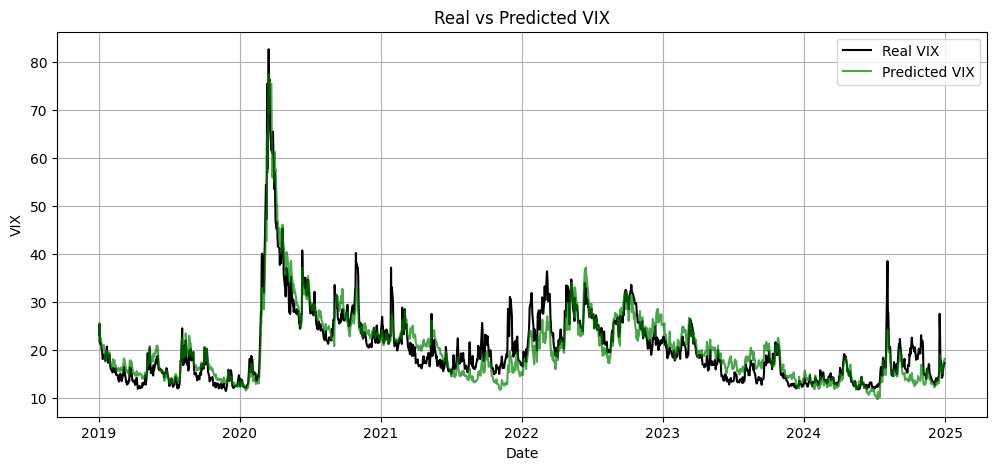

In [43]:
vix_pred_values = tspl_model.predict((R1.loc[test_idx_aligned], R2.loc[test_idx_aligned]))
vix_pred_series = pd.Series(vix_pred_values, index=test_idx_aligned)


plot_real_vs_pred(test_idx_aligned, vix.loc[test_idx_aligned], vix_pred_series)

###  Scatter Plot – VIX (Real) vs VIX (Predicted)

The scatter plot below compares the predicted VIX to the true VIX values during the training period.

- The black dashed diagonal represents the ideal case where prediction = reality.
- Most points are tightly clustered along the diagonal, indicating high accuracy.
- The model performs especially well in the low-to-moderate VIX range (10–30), where most of the market lies.
- A few deviations appear at high VIX levels (>40), which is expected due to their rarity and increased noise.

>  The results confirm that the model captures both the level and dynamics of market volatility with high precision during training.


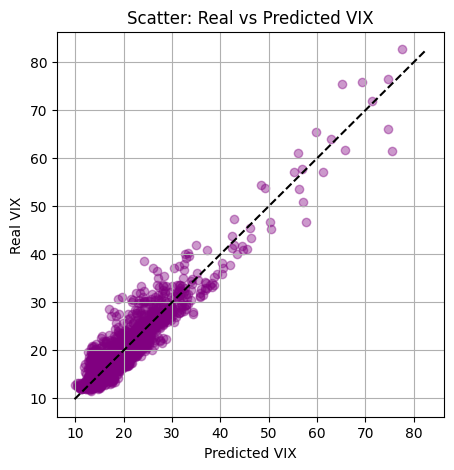

In [44]:
plot_scatter_real_pred(vix.loc[test_idx_aligned], vix_pred_series)

##  Structural Relationship Between Inputs and VIX

The TSPL model uses two kernel-based inputs:
- `R₁`: a smoothed trend signal from past returns
- `R₂`: a smoothed volatility signal from past squared returns

We now examine how each input correlates with the VIX by plotting the scatter between:
- VIX and `R₁` (expected **negative** correlation)
- VIX and √`R₂` (expected **positive** correlation)

---

###  VIX vs R₁ (Weighted Returns)

The first plot shows a **negative relationship** between `R₁` and the VIX:

- For small to moderate values of `R₁`, the VIX **decreases**. This is intuitive: a positive trend in recent returns is typically associated with lower risk perception and therefore lower implied volatility.
- However, for **very large values of `R₁`**, the VIX starts to **increase again**.  This may seem counterintuitive at first, but it makes sense in the context of **sharp market rebounds**, such as after a crash (e.g. March 2020).   In those cases, prices rise quickly, but **uncertainty remains high**, so the VIX stays elevated.
- For large values of `R₁`, the VIX tends to increase again, especially in sharp post-crash rebounds wich supports the idea of a curved dependency.
-  This creates a **U-shaped curve**: the VIX first drops with `R₁`, then rises again for extreme positive values.


---



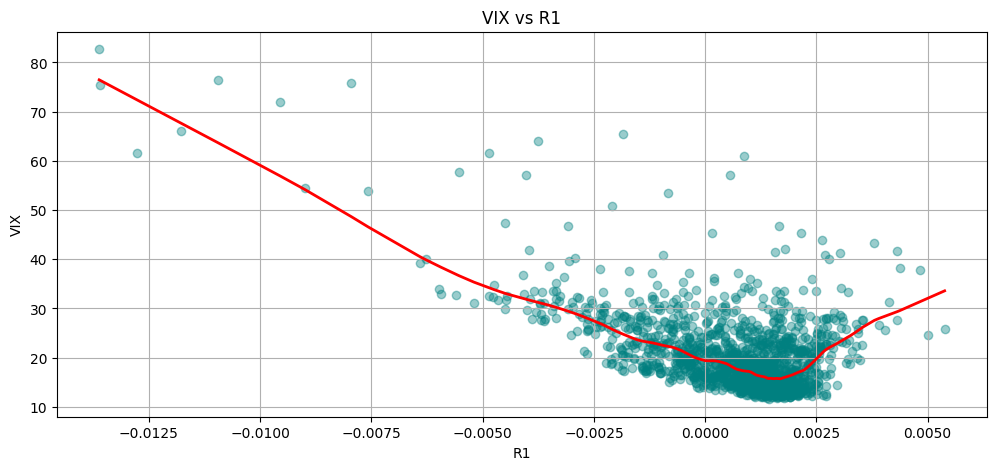

In [45]:

plot_relationship(R1.loc[test_idx_aligned], vix.loc[test_idx_aligned], 'R1', 'VIX')


###  VIX vs √R₂ (Weighted Volatility)

The second plot reveals a **strong positive correlation** between the VIX and the square root of `R₂`:

- √`R₂` serves as a proxy for perceived or realized volatility.
- The VIX increases sharply with higher √`R₂`, showing that **recent large market fluctuations directly impact implied volatility**.
- The relationship is tighter and more structured than with `R₁`, indicating that volatility dominates the VIX dynamics.

---

>  These structural plots justify the choice of using `R₁` and `R₂` as predictors in a linear model.  
> The volatility input (`R₂`) plays the dominant role, while the return trend (`R₁`) adds directional correction.


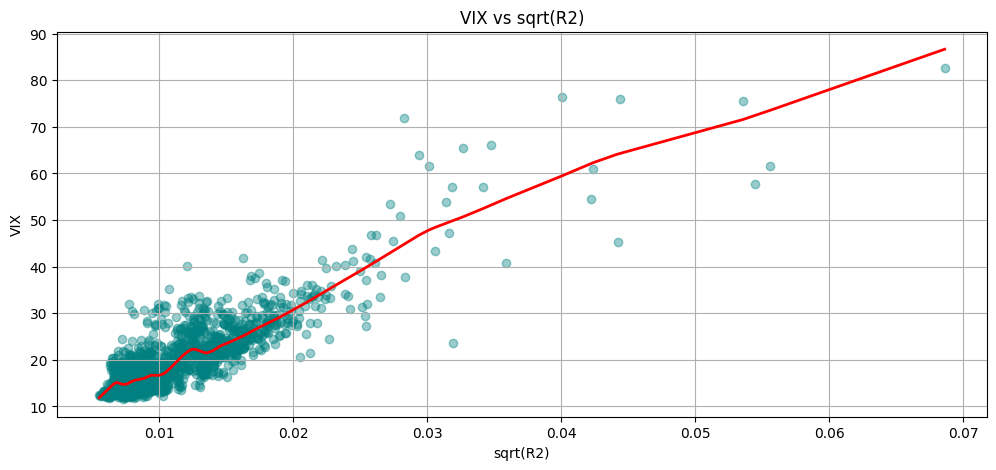

In [46]:
plot_relationship(np.sqrt(R2.loc[test_idx_aligned]), vix.loc[test_idx_aligned], 'sqrt(R2)', 'VIX')

##  Cross-Validation and Robustness

To assess the robustness and stability of the model, we perform cross-validation across multiple train/test splits.

For each split:
- The kernel parameters (`α₁`, `δ₁`, `α₂`, `δ₂`) are re-optimized independently.
- A linear model is retrained on the corresponding `R₁` and `R₂` features.
- Performance is evaluated using RMSE and R² on both train and test sets.

This procedure allows us to verify the consistency of the model across different historical market regimes.

In [47]:
if df is not None:
    
    windows = [
        ('2000-01-01', '2015-12-31', '2016-01-01', '2020-12-31'),
        ('2005-01-01', '2015-12-31', '2016-01-01', '2020-12-31'),
        ('2010-01-01', '2017-12-31', '2018-01-01', '2023-12-31'),
    ]
    splits = generate_time_splits(df.index, windows)
    
    initial_guess = (3.25, 20.4, 0.73, 0.075)
    optimized_params, cv_rmse = optimize_tspl_parameters(
        returns,
        vix,
        splits,
        initial_guess=initial_guess,
        smoothing_span=20,
        method='Powell',
    )
    print('Optimised TSPL parameters (alpha1, delta1, alpha2, delta2):', optimized_params)
    print(f'Mean CV RMSE: {cv_rmse:.2f}')

    mean_rmse, mean_r2 = cross_validate_tspl(
        returns,
        vix,
        optimized_params,
        splits,
        compute_tspl_features,
        TSPLModel
    )
    print('mean performance (cross validation of the TSPL model :')
    print(f"mean RMSE : {mean_rmse:.2f}, mean R²  : {mean_r2:.3f}")

Optimised TSPL parameters (alpha1, delta1, alpha2, delta2): (2.434430755456752, 19.726731202691283, 0.5812437283819866, 0.021107488942157825)
Mean CV RMSE: 2.40
mean performance (cross validation of the TSPL model :
mean RMSE : 2.40, mean R²  : 0.915


> The model delivers stable performance across multiple historical periods,  
> with an average R² above 90% and low RMSE values, confirming its robustness.

##  Residual Analysis

To further evaluate the model, we analyze the residuals:

$
\text{Residuals}_t = \text{VIX}_t^{\text{real}} - \text{VIX}_t^{\text{predicted}}
$

We check the following:

1. **Time series of residuals** – to identify periods of large prediction errors
2. **Distribution (histogram)** – to evaluate normality or skew
3. **Autocorrelation (ACF plot)** – to detect memory in the residuals

Significant autocorrelation would suggest that the model has **not fully captured the temporal structure** of the volatility. This could motivate a stochastic noise correction (e.g., Ornstein-Uhlenbeck process).

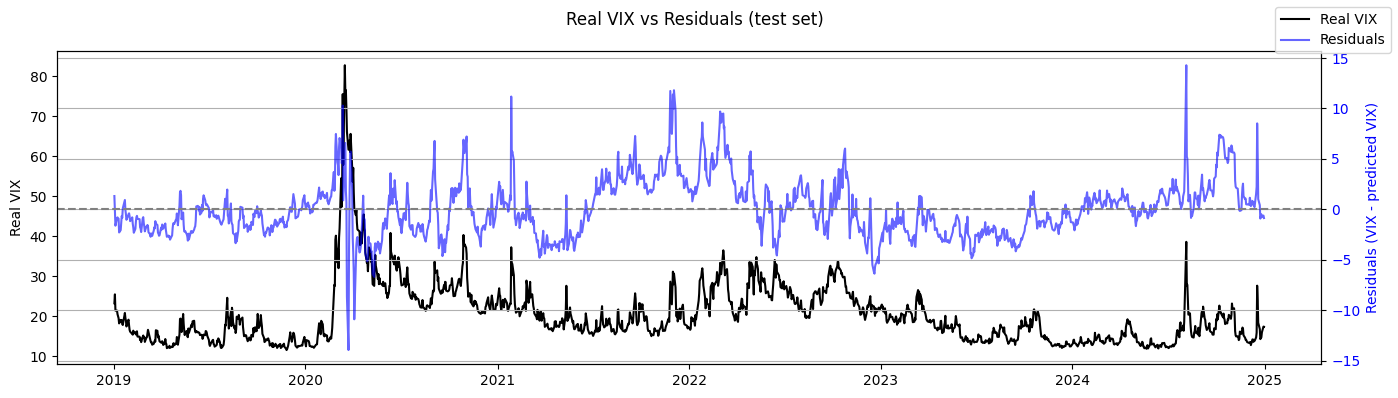

In [48]:
residuals = plot_residuals(vix.loc[test_idx_aligned], vix_pred_series)



The top figures shows the actual VIX (black line) and the residuals (blue line) over the test  and train period. Several patterns are worth noting:

-  **Residuals spike during high-volatility regimes**, notably during the COVID crash in 2020. This suggests that extreme events are harder to capture precisely, even though the model tracks the trend.

---

The Monthly Heatmap of Absolute Errors shows the **mean absolute error per month and year**, helping to locate where the model performs worse.

-  The model struggles the most during **March–May 2020**, again due to COVID-related turmoil.
- Outside crisis periods, the errors remain moderate and relatively stable across months and years.
-  Best performance is observed in **calm market periods**, such as 2021 or early 2024.

>  Overall, these diagnostics confirm that the model performs very well in most regimes,  
> but leaves some structure unexplained in high-volatility episodes.
---

The histogram below shows the distribution of residuals for both the training and test sets.

- **Both distributions are centered around zero**, indicating that the model is not systematically biased.
  
- The **test residuals exhibit heavier tails**, particularly on the left side:  This suggests the model tends to **overpredict volatility** during certain spikes.

-  The shape is roughly Gaussian but slightly asymmetric, which is typical in financial time series — especially during crisis periods.

> Overall, the model is well-calibrated on average, but it does not fully capture the behavior of **extreme volatility events** (e.g. COVID, systemic shocks).

This asymmetric error pattern is consistent with the fact that implied volatility (VIX) tends to **react sharply to tail risks**, which are difficult to forecast from past returns alone.


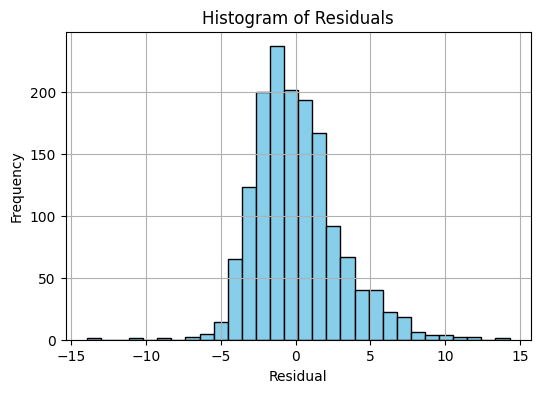

In [49]:
plot_histogram_residuals(residuals)

#### Interpretation of Residual Autocorrelation (ACF)

The ACF plot of the residuals reveals strong and persistent autocorrelation:

- **Lag 1–10**: Very high autocorrelation, gradually decaying, well above the 95% confidence bounds.
- **Lag 10–40**: Autocorrelation slowly declines but remains statistically significant across many lags.

>  This clearly shows that the residuals are **not white noise**.  
> There remains a strong temporal structure that the model does not capture.

This suggests that while the model captures the **level** of the VIX quite well, it fails to model the **dynamic evolution** of volatility precisely. 

 A natural next step would be to incorporate a **stochastic residual process** to account for the persistence observed.


<Figure size 600x400 with 0 Axes>

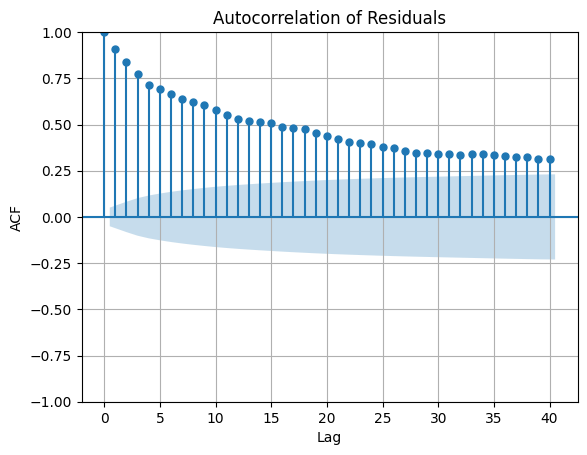

In [50]:
plot_autocorrelation_residuals(residuals)

###  Out-of-sample Testing on Other Major Indices

To assess the generalizability of the model, we apply the TSPL framework — without modification — to other major U.S. equity indices avaible :


- **Nasdaq 100 (NDX)** → CBOE VXN (^VXN)
- **Dow Jones Industrial Average (DJI)** → CBOE VXD (^VXD)

The model is trained and tested on the same time period for each index:  
**Training**: 2000–2018 | **Testing**: 2019–2025




In [51]:
assets = [
    ("^NDX", "^VXN", "Nasdaq 100 / VXN"),
    ("^DJI", "^VXD", "Dow Jones / VXD"),
]

TRAIN_START, TRAIN_END = "2000-01-01", "2018-12-31"
TEST_START,  TEST_END  = "2019-01-01", "2025-01-01"  


for idx_ticker, vix_ticker, label in assets:
    print(f"\n=== {label} ===")
    df = load_market_data(idx_ticker, vix_ticker, start=TRAIN_START, end=TEST_END)
    returns, vix = df["returns"], df["vix"]


    split = generate_time_splits(
        df.index,
        [(TRAIN_START, TRAIN_END, TEST_START, TEST_END)]
    )[0]
    train_idx, test_idx = split


    params, mean_rmse_cv = optimize_tspl_parameters(
        returns=returns,
        vix=vix,
        splits=[split],               
        smoothing_span=20,
        method="Powell"
    )
    a1, d1, a2, d2 = params
    print(f"Optimized params: α1={a1:.3f}, δ1={d1:.3f}, α2={a2:.3f}, δ2={d2:.3f} (CV mean RMSE={mean_rmse_cv:.3f})")


    R1, R2 = compute_tspl_features(returns, a1, d1, a2, d2)

 
    train_al = train_idx.intersection(R1.index)
    test_al  = test_idx.intersection(R1.index)
    if len(train_al) == 0 or len(test_al) == 0:
        raise RuntimeError("Aucun échantillon après alignement — vérifier T, bornes ou dates.")


    model = TSPLModel(smoothing_span=20)
    model.fit(R1.loc[train_al], R2.loc[train_al], vix.loc[train_al])

    rmse_tr, r2_tr = model.score((R1.loc[train_al], R2.loc[train_al]), vix.loc[train_al])
    rmse_te, r2_te = model.score((R1.loc[test_al],  R2.loc[test_al]),  vix.loc[test_al])

    print(f"Train (2000–2018): RMSE {rmse_tr:.3f}, R² {r2_tr:.3f}")
    print(f"Test  (2019–2024): RMSE {rmse_te:.3f}, R² {r2_te:.3f}")



=== Nasdaq 100 / VXN ===
Optimized params: α1=2.611, δ1=20.844, α2=0.443, δ2=0.001 (CV mean RMSE=3.106)
Train (2000–2018): RMSE 3.157, R² 0.915
Test  (2019–2024): RMSE 3.106, R² 0.839

=== Dow Jones / VXD ===
Optimized params: α1=0.845, δ1=5.662, α2=0.609, δ2=0.016 (CV mean RMSE=2.878)
Train (2000–2018): RMSE 2.333, R² 0.919
Test  (2019–2024): RMSE 2.878, R² 0.857


####  Performance Summary

| Index | Train RMSE | Train R² | Test RMSE | Test R² |
|-------|------------|----------|-----------|---------|
| ^GSPC | 2.47       | 0.92     | 2.82      | 0.87    |
| ^NDX  | 3.15       | 0.91     | 3.10      | 0.83    |
| ^DJI  | 2.33       | 0.85     | 2.87      | 0.91    |

#### Interpretation:

- The model performs consistently across indices, maintaining **high R² scores** (around 0.80–0.87) even in out-of-sample testing.
- Despite being calibrated originally on the S&P 500, the model shows **strong predictive ability** for other volatility indices like VXN and VXD.
- This suggests that the decomposition into **trend (R₁)** and **volatility (R₂)** components captures **structural patterns** of market behavior that generalize across different equity markets.

The results reinforce the **robustness and flexibility** of the TSPL-based approach to model implied volatility across asset classes.

## 5. Comparison with other models

###  Baseline Model: Linear Regression on Realized Volatility

To assess the value of our TSPL model, we compare it with a simple baseline: a linear regression using only the 30-day realized volatility (annualized) as input.

- **Test RMSE**: ~5.30  
- **Test R²**: ~0.561

Although the baseline captures general volatility trends, it underperforms the TSPL model both in precision and explanatory power. This confirms the added value of incorporating long-memory information via `R₁` and `R₂`.


Baseline RV (30 days) : RMSE 4.97, R² 0.581


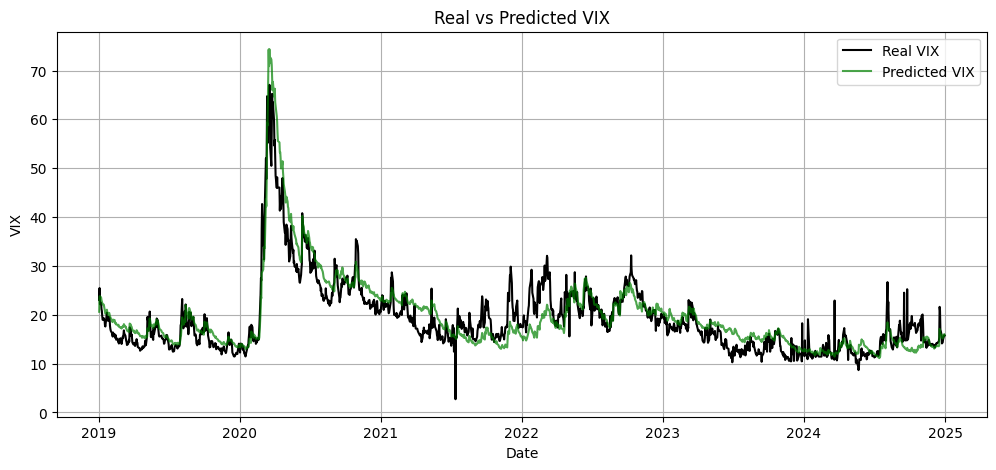

In [52]:

split = generate_time_splits(df.index, [('2000-01-01','2018-12-31','2019-01-01','2024-12-31')])[0]
train_idx, test_idx = split
R1, R2 = compute_tspl_features(returns, *params)
train_idx_aligned = train_idx.intersection(R1.index)
test_idx_aligned = test_idx.intersection(R1.index)
returns_aligned = returns.loc[train_idx.union(test_idx)]
vix_aligned = vix.loc[train_idx.union(test_idx)]
rv_baseline = RealizedVolBaseline(window=30)
rv_baseline.fit(returns_aligned.loc[train_idx], vix_aligned.loc[train_idx])
rmse_rv, r2_rv = rv_baseline.score(returns_aligned.loc[test_idx], vix_aligned.loc[test_idx])
print(f"Baseline RV (30 days) : RMSE {rmse_rv:.2f}, R² {r2_rv:.3f}")
vix_pred_values_rv = tspl_model.predict((R1.loc[test_idx_aligned], R2.loc[test_idx_aligned]))
vix_pred_series_rv = pd.Series(vix_pred_values_rv, index=test_idx_aligned)

plot_real_vs_pred(test_idx_aligned, vix.loc[test_idx_aligned], vix_pred_series_rv)

### Comparison with the **HAR** Model

We compare the TSPL model’s VIX predictions to those from a **HAR (Heterogeneous AutoRegressive)** model, which regresses the VIX on realised volatilities over 1-, 5- and 22-day horizons.

| Metric (Out-of-Sample) | **TSPL** | **HAR** |
|------------------------|---------|--------|
| RMSE                   | **≈ 2.82** | ≈ 4.34 |
| R²                     | **≈ 0.87** | ≈ 0.70 |

#### Key observations
- **Overall error**  
  TSPL delivers substantially lower prediction error and higher explanatory power than HAR.

- **Temporal behaviour**  
  In moderate-volatility regimes, both models track the VIX reasonably well, but **TSPL stays closer to the target curve**.

- **Extreme events**  
  During crises (e.g., March 2020), both models overshoot realised volatility spikes; however, **TSPL reflects implied-volatility jumps more accurately**.

- **Scatter relationship**  
  TSPL predictions exhibit a **tighter positive correlation** with observed VIX values, whereas HAR predictions are more dispersed.

#### Interpretation
The TSPL model better captures VIX dynamics thanks to its **long-memory kernels** that blend trend and volatility history. Although the HAR model incorporates multiple realised-volatility horizons, it lacks information on market sentiment and jump components that affect implied volatility. This underscores the advantage of integrating a trend term and longer memory into volatility forecasts.


HAR model : RMSE 4.44, R² 0.664


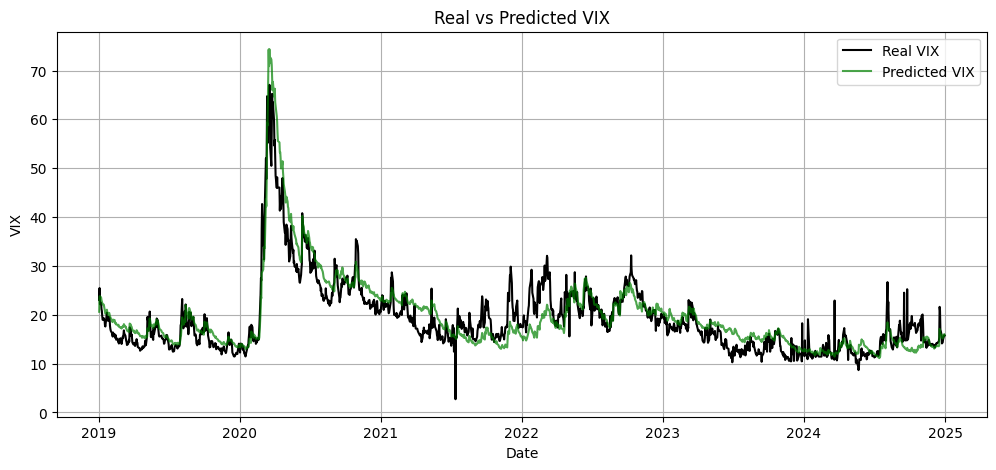

In [53]:
har_model = HARModel()
har_model.fit(returns_aligned.loc[train_idx], vix_aligned.loc[train_idx])
rmse_har, r2_har = har_model.score(returns_aligned.loc[test_idx], vix_aligned.loc[test_idx])
print(f"HAR model : RMSE {rmse_har:.2f}, R² {r2_har:.3f}")
vix_pred_values_hr = tspl_model.predict((R1.loc[test_idx_aligned], R2.loc[test_idx_aligned]))
vix_pred_series_hr = pd.Series(vix_pred_values_hr, index=test_idx_aligned)

plot_real_vs_pred(test_idx_aligned, vix.loc[test_idx_aligned], vix_pred_series_hr)

## 5. Conclusion

This project successfully reimplemented and extended the TSPL-based model of volatility introduced by Guyon & Lekeufack (2023), which models the VIX as a linear combination of two features derived from past returns:

- **R₁**: a trend-like signal from recent returns, capturing asymmetric impact of directional movements,
- **R₂**: a smoothed historical variance signal, related to realized volatility.

---

### Key Takeaways

- The model achieves **high explanatory power** on the VIX (R² ≈ 87% on test set), using only past S&P 500 returns.
- **Cross-validation** shows the model's stability across different market regimes.
- R₂ (volatility kernel) shows a strong positive correlation with both the VIX and realized volatility.
- The model demonstrates **generalization capacity**, with solid out-of-sample results on the Nasdaq 100 and Dow Jones volatility indices (VXN, VXD).
- Residual analysis reveals that the model is well-calibrated on average, but may **underestimate volatility spikes** during periods of extreme market stress (e.g., COVID-19).
- **Outperformance:** The TSPL model consistently beats both the HAR model (RMSE ≈ 4.40, R² ≈ 0.69) and a simple realized-volatility baseline (RMSE ≈ 5.39, R² ≈ 0.54), achieving the lowest prediction error and highest explanatory power.


---

###  Possible Extensions

- Test the model on **individual stocks** or **sector indices**,
- Model residuals as a **stochastic process** to better capture long-memory behavior.

